In [2]:
import numpy as np
import pandas as pd
from scipy import stats

from dataclasses import dataclass
from typing import Tuple


from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter

%load_ext autoreload
%autoreload 2

2025-05-06 11:30:28.570651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 11:30:28.582100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 11:30:28.585921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 11:30:29.241445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') 

In [4]:
index = osc.get_index(dfres.odor,4.5)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign



In [5]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

<!-- #### Likelihood of Estimation of probability - Gaussian Prob + Real world -  -->

Optimal Parameters:
A = 0.01005973056052619
x0 = 0.0
y0 = 0.0
sigma_y = 0.2
dy = 0.55
dist x = 0.02


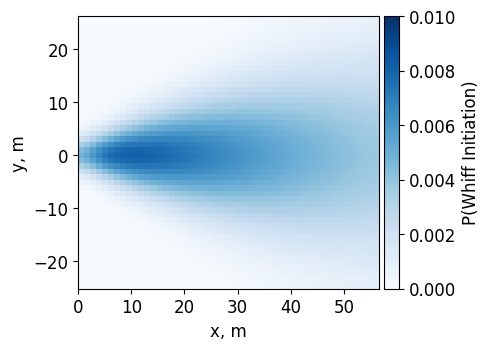

In [6]:
n_bins_x = n_bins_y = 50
heatmap_whiff, xedges, yedges = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y], 
    weights=dfres['whiff_flag']
)

heatmap_total, _, _ = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y]
)

# Calculate empirical probabilities (Equation 1)
with np.errstate(divide='ignore', invalid='ignore'):
    heatmap_prob = np.divide(
        heatmap_whiff, 
        heatmap_total, 
        out=np.zeros_like(heatmap_whiff), 
        where=heatmap_total != 0
    )

# Set up grid for analysis
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Prepare data for optimization
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Filter valid bins
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
    distance_x = x - x0
    distance_y = y - y0
    # distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # Simple sigma_y growth
    sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)  # stronger growth with distance
    
    # Basic Gaussian terms
    gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
    decay_term_x = np.exp(-decay_factor_x * distance_x)
    
    return A * gaussian_y * decay_term_x

bounds = [
    (0, 1),  # A (amplitude)
    (0, 0),          # x0 fixed
    (0, 0),          # y0 fixed
    (0.2, 5.0),      # base_sigma_y
    (0.55, 2.0),     # distance_scale_factor_y - for gradual spread
    (0.02, 1)        # decay_factor_x
]

# initial_params = [0.01, 0.0, 0.0, 0.1, 1.0, 0.02]
initial_params = [0.5, 0.0, 0.0, 0.1, 0.8, 0.02] 

# Negative log-likelihood function
def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x = params
    p = directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_y = {optimal_params[3]}")
print(f"dy = {optimal_params[4]}")
print(f"dist x = {optimal_params[5]}")


# Compute fitted probabilities
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
# After calculating fitted_p
scaling_factor = 1.15  # adjust this value as needed
fitted_p = fitted_p * scaling_factor
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2  # Narrower smoothing for sharper transitions
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(
    fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing
)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')
mpl_functions.set_fontsize(f,12)
f.tight_layout()


In [7]:
# np.savez('../data/simulator/hws/hmap.npz', fitted_heatmap=smoothed_fitted_p_heatmap, xedges=xedges, yedges=yedges)

In [8]:
fitted_p_heatmap_1=smoothed_fitted_p_heatmap
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob

In [9]:
df_test=dfres[10000:]

# Or in one line:
# df_test = dfres[(dfres['time'] >= 2000) & (dfres['time'] <= 2400)]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time

rows_per_second = 200
base_odor_level = 0.6 

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
whiff_intermittency=fdf.odor_intermittency.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

/tmp/ipykernel_2947834/2055345589.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [10]:
### ONLY SPATIAL MODEL
# odor_concentration_samples = np.full(len(df_test), base_odor_level)
# whiff_prediction_samples = np.zeros(len(df_test), dtype=int)


# distance_threshold = 4
# rows_per_second = 200
# base_odor_level = 0.58 
# def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
#     x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
#     y_bin = np.digitize(y, yedges) - 1

#     if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
#         return False, 0  # No valid bin, so no whiff predicted, probability is 0
#     whiff_prob = hmap[x_bin, y_bin]
#     whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

#     return whiff_predicted, whiff_prob
# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)

#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill  # Move index by the number of filled rows
#     else:
#         i += 1  

# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples



Odor Predictor Class

In [69]:
def logit(x, lower=0.0, upper=10.0, eps=1e-8):
    """
    Convert x in [lower, upper] to an unbounded real z in (-inf, +inf).
    We clamp x slightly to avoid taking log(0).
    """
    x_clamped = np.clip(x, lower + eps, upper - eps)
    scale = upper - lower
    ratio = (x_clamped - lower) / scale
    return np.log(ratio / (1 - ratio))

def inv_logit(z, lower=0.0, upper=10.0):
    """
    Convert an unbounded real z in (-inf, +inf) back to [lower, upper].
    """
    scale = upper - lower
    return lower + scale / (1.0 + np.exp(-z))

class OdorStateManager:
    def __init__(self, config, whiff_intermittency):
        # Start odor at base level, but store internally in z-space
        z_init = logit(config.base_odor_level, 0, 10)
        self.z_current = z_init
        self.z_prev    = z_init

        # For reference/tracking we also keep actual odor in [0..10]
        # (initialized to the base_odor_level).
        self.current_concentration = config.base_odor_level
        self.prev_concentration    = config.base_odor_level

        # For other state logic
        self.recent_history        = [0] * 1000
        self.recent_concentrations = [config.base_odor_level] * 10
        self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 7))
        self.in_whiff_state = False
        self.state_duration = 0

@dataclass
class OdorConfig:
    rows_per_second: int = 200
    base_odor_level: float = 0.6
    distance_threshold: float = 3
    # AR(2) base coefficients
    ar1: float = 0.98
    ar2: float = -0.02
    warmup_steps: int = 1000
    low_threshold: float = 0.05
    history_length: int = 7
    # Transition matrix for whiff states
    transition_matrix: np.ndarray = np.array([[0.15, 0.85],
                                              [0.15, 0.85]])

class ParallelOdorPredictor:
    def __init__(self, df_test: pd.DataFrame, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        self.config = OdorConfig()
        self.df_test = df_test
        self.fdf = fdf
        self.fdf_nowhiff = fdf_nowhiff
        self.setup_data()

    def setup_data(self):
        distance_bins = np.arange(0, 51, 5)  # [0, 15, 30, 45, 60]
        nearest_bins = np.arange(-15, 16, 5)  
        
        self.bin_data_dict = {}
        
        for i in range(len(distance_bins)-1):
            for j in range(len(nearest_bins)-1):
                start_dist, end_dist = distance_bins[i], distance_bins[i+1]
                start_near, end_near = nearest_bins[j], nearest_bins[j+1]
                
                bin_data = self.fdf[
                    (self.fdf['avg_distance_along_streakline'] >= start_dist) & 
                    (self.fdf['avg_distance_along_streakline'] < end_dist) &
                    (self.fdf['avg_nearest_from_streakline'] >= start_near) &
                    (self.fdf['avg_nearest_from_streakline'] < end_near)
                ]['odor_intermittency'].dropna().values
                
                self.bin_data_dict[(start_dist, end_dist, start_near, end_near)] = bin_data
    @staticmethod
    def calculate_distance_from_source(x: float, y: float) -> float:
        """Euclidean distance from source (assume (0,0)) to point (x,y)."""
        return np.sqrt(x**2 + y**2)

    def generate_intermittency(self, distance_along: float, distance_from: float,
                           state: OdorStateManager, default: float = 0.05) -> float:
        last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
        low_frequency = np.mean(last_values < self.config.low_threshold)
        
        for (sd, ed, sn, en), values in self.bin_data_dict.items():
            if (sd <= distance_along < ed) and (sn <= distance_from < en):
                if len(values) > 0:
                    if low_frequency > 0.5:
                        median_val = np.median(values)
                        subset = values[values < median_val]
                        if len(subset) > 0:
                            intermittency = np.random.choice(subset)
                        else:
                            intermittency = np.random.choice(values)
                    else:
                        intermittency = np.random.choice(values)
                    return np.clip(intermittency, np.min(values), np.max(values))
        return default

    # ------------------------------------
    # 3c) Update whiff posterior
    # ------------------------------------
    def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
        """
        Example function to incorporate a Markov chain / state transition
        plus some heuristics about recent whiffs, etc.
        """
        scaler=0.25
        # whiff_state = 1 if state.in_whiff_state else 0
        num_recent_whiffs = sum(state.recent_history[-20:])
        
        # Time since last whiff
        time_since_whiff = 0
        for i in range(len(state.recent_history)-1, -1, -1):
            if state.recent_history[i]:
                break
            time_since_whiff += 1
        
        time_since_last_whiff = min(1.5, time_since_whiff ) if time_since_whiff > 50 else 1.0
        recent_whiff_memory = (1 + (num_recent_whiffs ) * scaler) * time_since_last_whiff
                
        posterior = (prior_prob * scaler * 0.85  * recent_whiff_memory)
                    #  * concentration_factor)
        
        return posterior
    
    def update_ar2_concentration(self, current: float, prev: float, target: float, 
                               noise_scale: float) -> float:
        noise = noise_scale * (np.random.randn() - 0.5) * 0.5
        x_next = (0.85 * (self.config.ar1 * (current - target) + 
                 self.config.ar2 * (prev - target)) + target + noise)
        return x_next

    # def update_ar2_in_zspace(self, z_current: float, z_prev: float,
    #                          z_target: float, distance: float,
    #                          base_noise_scale: float = 0.1,
    #                          jump_prob: float = 0.05) -> float:
    #     """
    #     Perform an AR(2)-like update, but in 'z' (logit) space, so that
    #     when we transform back via inv_logit, the odor is guaranteed in [0,10].
        
    #     distance is used to modulate noise or AR coefficients if desired.
    #     """
    #     # Distance factor to damp or intensify fluctuations
    #     distance_factor = np.exp(-distance / 50.0)  # decays with distance

    #     # Possibly adjust AR(1), AR(2), etc. coefficients
    #     ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
    #     ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
        
    #     # Base random noise
    #     noise = base_noise_scale * (1 + 2 * distance_factor) * np.random.randn()
        
    #     # Optional “jumps”
    #     if np.random.rand() < jump_prob:
    #         jump_size = np.random.uniform(-1, 1) * base_noise_scale * 3
    #         noise += jump_size

    #     # AR(2) update in unbounded space
    #     z_next = 0.85 * (ar1_local * (z_current - z_target)
    #                      + ar2_local * (z_prev - z_target)) \
    #              + z_target + noise

    #     return z_next

    def update_ar2_in_zspace(self, z_current: float, z_prev: float,
                            z_target: float, distance: float,
                            std_dev_whiff: float,
                            jump_prob: float = 0.05) -> float:
        """
        Perform an AR(2)-like update with the empirical WSD properly converted to logit space.
        
        Parameters:
        -----------
        z_current, z_prev: Current and previous states in logit space
        z_target: Target value in logit space
        distance: Distance from source
        std_dev_whiff: The empirically measured standard deviation in concentration space
        jump_prob: Probability of adding a larger jump to the noise
        """
        # Distance factor still useful for modulating overall dynamics
        distance_factor = np.exp(-distance / 50.0)  
        
        # Adjust AR coefficients based on distance
        ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
        ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
        
        # Convert target to concentration space
        target_concentration = inv_logit(z_target, 0, 10)
        
        # Use the empirical WSD to define bounds in concentration space
        upper_bound = min(target_concentration + std_dev_whiff, 9.9)
        lower_bound = max(target_concentration - std_dev_whiff, 0.1)
        
        # Convert these bounds to logit space
        z_upper = logit(upper_bound, 0, 10)
        z_lower = logit(lower_bound, 0, 10)
        
        # The standard deviation in logit space 
        z_std = (z_upper - z_lower) / 2.0
        
        # Apply distance factor to modulate variability
        # Higher variability near source, lower far away
        effective_std = z_std * (1.0 + distance_factor)
        
        # Generate noise in logit space
        noise = effective_std * np.random.randn()
        
        # Optional "jumps"
        if np.random.rand() < jump_prob:
            jump_size = np.random.uniform(-1, 1) * effective_std * 2
            noise += jump_size

        # AR(2) update in unbounded space
        z_next = 0.85 * (ar1_local * (z_current - z_target)
                        + ar2_local * (z_prev - z_target)) \
                + z_target + noise

        return z_next
    # ------------------------------------
    # 3e) Main loop over data
    # ------------------------------------
    def process_segment(self, start_idx: int, end_idx: int,
                    state: OdorStateManager) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        segment = self.df_test.iloc[start_idx:end_idx]

        # Add arrays for intermediate outputs
        concentrations = np.full(len(segment), self.config.base_odor_level)
        predictions = np.zeros(len(segment), dtype=int)
        logistic_transforms = np.zeros(len(segment))
        ar2_outputs = np.zeros(len(segment))
        target_concentrations = np.zeros(len(segment))  # New array for targets

        test_locations = segment[['distance_along_streakline','nearest_from_streakline']].values
        whiff_locations = self.fdf[['avg_distance_along_streakline','avg_nearest_from_streakline']].values
        nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline','avg_nearest_from_streakline']].values

        distances_from_source = np.array([
            self.calculate_distance_from_source(x, y) 
            for x, y in test_locations
        ])
        distances = cdist(test_locations, whiff_locations)
        distances_nowhiff = cdist(test_locations, nowhiff_locations)

        i = 0
        while i < len(segment):
            if start_idx + i < self.config.warmup_steps:
                i += 1
                continue

            prior_prob = segment.spatial_prob.iloc[i]
            posterior = self.update_whiff_posterior(prior_prob, state)

            if state.in_whiff_state:
                state.state_duration += 1
                min_duration = 0.1 * self.config.rows_per_second
                if state.state_duration > min_duration:
                    continue_prob = 0.5 * prior_prob
                    state.in_whiff_state = (np.random.rand() < continue_prob)
            else:
                transition_prob = posterior
                state.in_whiff_state = (np.random.rand() < transition_prob * 0.5)
                if state.in_whiff_state:
                    state.state_duration = 0

            if state.in_whiff_state and (np.min(distances[i]) <= self.config.distance_threshold):
                nearest_idx = np.argmin(distances[i])
                mean_concentration = self.fdf.mean_concentration.values[nearest_idx]
                std_dev_whiff = self.fdf.std_whiff.values[nearest_idx]
                duration = int(self.fdf.length_of_encounter.values[nearest_idx] *
                            self.config.rows_per_second)
                rows_to_fill = min(duration, len(segment) - i)

                z_target = logit(mean_concentration, 0, 10)

                for j in range(rows_to_fill):
                    dist_here = distances_from_source[i + j] if (i+j) < len(distances_from_source) else 0
                    
                    # Save target concentration
                    target_concentrations[i+j] = mean_concentration
                    
                    # Save logistic transform
                    logistic_transforms[i+j] = z_target
                    
                    # AR(2) update and save intermediate
                    z_next = self.update_ar2_in_zspace(
                        state.z_current, state.z_prev, z_target,
                        distance=dist_here,
                        # base_noise_scale=0.4 * std_dev_whiff,
                        std_dev_whiff=std_dev_whiff,
                        jump_prob=0.1
                    )
                    ar2_outputs[i+j] = z_next
                    
                    odor_next = inv_logit(z_next, 0, 10)

                    state.z_prev = state.z_current
                    state.z_current = z_next
                    state.prev_concentration = state.current_concentration
                    state.current_concentration = odor_next

                    concentrations[i+j] = odor_next
                    predictions[i+j] = 1

                    state.recent_concentrations.append(odor_next)
                    state.recent_concentrations.pop(0)
                    state.recent_history.append(1)
                    state.recent_history.pop(0)

                i += rows_to_fill

                dist_along = segment.distance_along_streakline.iloc[i-1]
                dist_from = segment.nearest_from_streakline.iloc[i-1]
                intermittency = self.generate_intermittency(dist_along, dist_from, state)
                state.recent_intermittencies.append(intermittency)
                state.recent_intermittencies.pop(0)

                intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
                i += intermittency_duration

            else:
                nearest_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.fdf_nowhiff.wc_nowhiff.values[nearest_idx]
                no_whiff_std = self.fdf_nowhiff.wsd_nowhiff.values[nearest_idx]
                
                # Save target concentration for no-whiff state
                target_concentrations[i] = no_whiff_mean
                
                # Save logistic transform of no-whiff mean
                logistic_transforms[i] = logit(no_whiff_mean, 0, 10)
                
                new_concentration = self.update_ar2_concentration(
                    state.current_concentration,
                    state.prev_concentration,
                    no_whiff_mean,
                    0.05 * no_whiff_std
                )
                
                # Save AR(2) output
                ar2_outputs[i] = logit(new_concentration, 0, 10)
                
                new_concentration = np.clip(new_concentration, 0.6, 1.0)
                
                if i >= 10:
                    window_data = concentrations[i-10:i]
                    window_data = np.append(window_data, new_concentration)
                    window = np.ones(10)/10.0
                    new_concentration = np.convolve(window_data, window, mode='valid')[-1]
                
                state.prev_concentration = state.current_concentration
                state.current_concentration = new_concentration
                
                concentrations[i] = new_concentration
                state.recent_concentrations.append(new_concentration)
                state.recent_concentrations.pop(0)
                state.recent_history.append(0)
                state.recent_history.pop(0)
                
                i += 1

        return concentrations, predictions, logistic_transforms, ar2_outputs, target_concentrations

    def predict(self) -> pd.DataFrame:
        segment_size = 2000
        total_segments = (
            len(self.df_test) // segment_size +
            (1 if len(self.df_test) % segment_size else 0)
        )

        all_concentrations = []
        all_predictions = []
        all_logistic_transforms = []
        all_ar2_outputs = []
        all_target_concentrations = []  # New list for targets

        state = OdorStateManager(self.config, self.fdf.odor_intermittency.values)

        for seg_idx in range(total_segments):
            start_idx = seg_idx * segment_size
            end_idx = min((seg_idx + 1) * segment_size, len(self.df_test))

            concentrations, predictions, logistic_transforms, ar2_outputs, target_concentrations = self.process_segment(
                start_idx, end_idx, state)
                
            all_concentrations.append(concentrations)
            all_predictions.append(predictions)
            all_logistic_transforms.append(logistic_transforms)
            all_ar2_outputs.append(ar2_outputs)
            all_target_concentrations.append(target_concentrations)  # Add targets

        # Concatenate all results
        final_concentrations = np.concatenate(all_concentrations)
        final_predictions = np.concatenate(all_predictions)
        final_logistic_transforms = np.concatenate(all_logistic_transforms)
        final_ar2_outputs = np.concatenate(all_ar2_outputs)
        final_target_concentrations = np.concatenate(all_target_concentrations)  # Concatenate targets
        
        final_concentrations = gaussian_filter(final_concentrations, sigma=0.8)

        self.df_test.loc[:, 'predicted_odor'] = final_concentrations
        self.df_test.loc[:, 'whiff_predicted'] = final_predictions
        self.df_test.loc[:, 'logistic_transform'] = final_logistic_transforms
        self.df_test.loc[:, 'ar2_output'] = final_ar2_outputs
        self.df_test.loc[:, 'target_concentration'] = final_target_concentrations  # Add targets column
        
        return self.df_test

def main():
    predictor = ParallelOdorPredictor(df_test, fdf, fdf_nowhiff)
    result_df = predictor.predict()
    
    # # Create the visualization
    # fig = plot_intermediate_outputs(result_df)
    
    
    return result_df

if __name__ == "__main__":
    test_result = main()
    df_test.loc[:, 'predicted_odor'] = test_result['predicted_odor']
    df_test.loc[:, 'whiff_predicted'] = test_result['whiff_predicted']
    df_test.loc[:, 'logistic_transform'] = test_result['logistic_transform']
    df_test.loc[:, 'ar2_output'] = test_result['ar2_output']
    df_test.loc[:, 'target_concentration'] = test_result['target_concentration']

In [96]:
from plume_sim_batch import COSMOS

dirname = '../data/simulator/hws/'
hmap_data = np.load(str(dirname) + "hmap.npz")
fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')
df_test = pd.read_hdf(str(dirname) + 'hws_jan22.h5')  # Your test data
# df_test = dfres[10000:]

# Extract required parameters
test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
fitted_p_heatmap = hmap_data['fitted_heatmap']
xedges = hmap_data['xedges']
yedges = hmap_data['yedges']

# Create predictor directly and customize if needed
predictor = COSMOS(
    fitted_p_heatmap=fitted_p_heatmap,
    xedges=xedges,
    yedges=yedges,
    fdf=fdf,
    fdf_nowhiff=fdf_nowhiff,
    test_locations=test_locations
)
results = predictor.predict()

# Use the results
df_test.loc[:, 'predicted_odor'] = results['concentrations']
df_test.loc[:, 'whiff_predicted'] = results['predictions']
df_test.loc[:, 'logistic_transform'] = results['logistic_transform']
df_test.loc[:, 'ar2_output'] = results['ar2_output']
df_test.loc[:, 'target_concentration'] = results['target_concentration']

In [97]:
th=4.5
query1 = 'odor>'+ str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+ str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

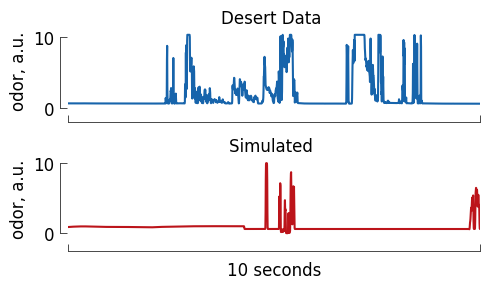

In [98]:
f,ax= plt.subplots(2,1,figsize=(5,3))
ax[0].plot(df_test.time, df_test.odor, label='original', c='#1764ab')
ax[1].plot(df_test.time, df_test.predicted_odor, label='predicted', c='#bc141a')
# ax[0].axhline(4.5, color = 'r', linestyle = '--')
# ax[1].axhline(4.5, color = 'r', linestyle = '--')
limit = (360,370)
ax[0].set_xlim(limit)
ax[1].set_xlim(limit)

# ax2.set_ylim(0,11)
ax[0].set_ylabel('odor, a.u.')
ax[1].set_ylabel('odor, a.u.')
ax[1].set_xlabel('10 seconds')
ax[0].set_title('Desert Data ')
ax[1].set_title('Simulated ')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 6}, 
                            smart_bounds=True,
                            xticks=[360,370],
                            yticks=[0, 10],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],12)
f.tight_layout()

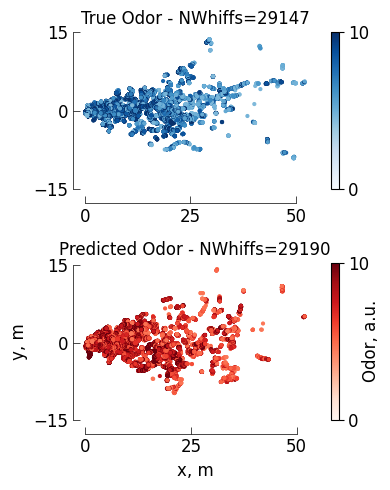

In [99]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Reds', vmin=0, vmax=10)
ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[0].set_title('Desert Data')
# ax[1].set_title('Simulated')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,15],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],12)

f.tight_layout()

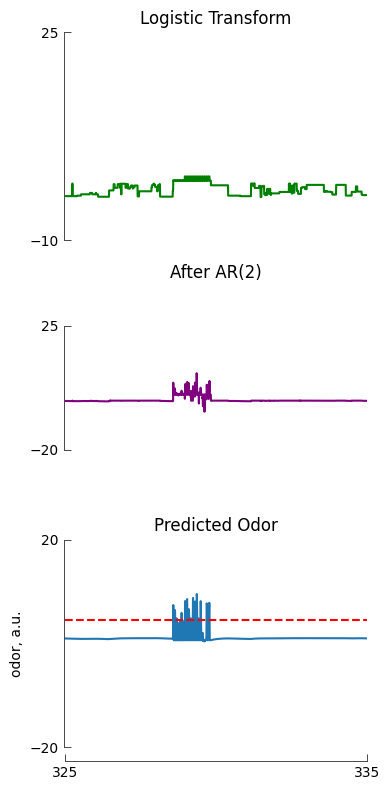

In [100]:
f, (ax2, ax3, ax4) = plt.subplots(3, 1, figsize=(4, 8))
time_limit=[325,335]

# Logistic Transform
ax2.plot(df_test.time, df_test.logistic_transform, label='logistic', color='green')
ax2.set_title('Logistic Transform')
ax2.set_xlim(time_limit)

# AR(2) Output
ax3.plot(df_test.time, df_test.ar2_output, label='AR(2)', color='purple')
ax3.set_title('After AR(2)')
ax3.set_xlim(time_limit)

# Final Prediction
ax4.plot(df_test.time, df_test.predicted_odor, label='predicted')
ax4.axhline(4.5, color='r', linestyle='--')
ax4.set_title('Predicted Odor')
ax4.set_xlim(time_limit)
# ax4.set_xlabel('5 seconds')
ax4.set_ylabel('odor, a.u.')

# Remove x-axis labels for all but bottom plot

ax2.set_xticklabels([])
ax3.set_xticklabels([])

# Set consistent font size
# for ax in [ax2, ax3, ax4]:
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                 ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(12)

mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=time_limit,
                            yticks=[-10,25],
                            linewidth=0.5)

mpl_functions.adjust_spines(ax3,['left'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=time_limit,
                            yticks=[-20,25],
                            linewidth=0.5)

mpl_functions.adjust_spines(ax4,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=time_limit,
                            yticks=[-20,20],
                            linewidth=0.5)

f.tight_layout()

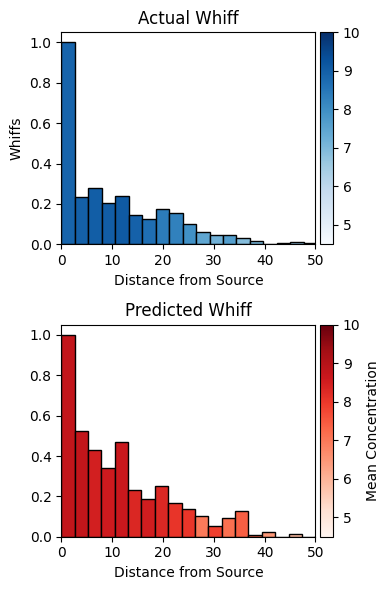

In [101]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.Blues(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='Blues', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.Reds(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='Reds', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



In [102]:
# df_test=pd.read_hdf('../data/simulator/plot/Figure 2/hws_jan22.h5') 

In [103]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [104]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

In [105]:
# df_test.to_hdf('../data/simulator/plot/hws_jan22.h5', mode='w', key='df_test')
# fdf_predicted.to_hdf('../data/simulator/plot/odor_pr_stat.h5', mode='w', key='fdf_predicted')

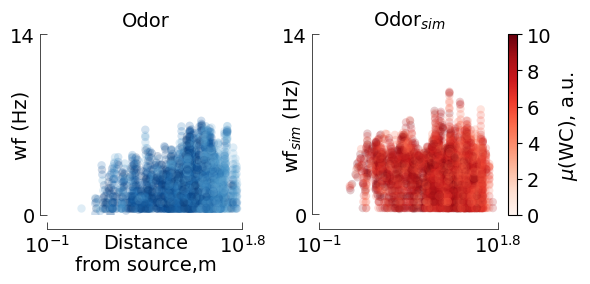

In [106]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='Blues', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='Reds', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{sim}$')
ax1.set_xlabel('Distance\nfrom source,m')
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{sim}$ (Hz)')


# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 5},
                            smart_bounds=True,
                            xticks=[-1, 1.8],
                            yticks=[0, 14],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 5},
                            smart_bounds=True,
                            xticks=[-1, 1.8],
                            yticks=[0, 14],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
# ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

100%|██████████| 1000/1000 [00:00<00:00, 8338.83it/s]


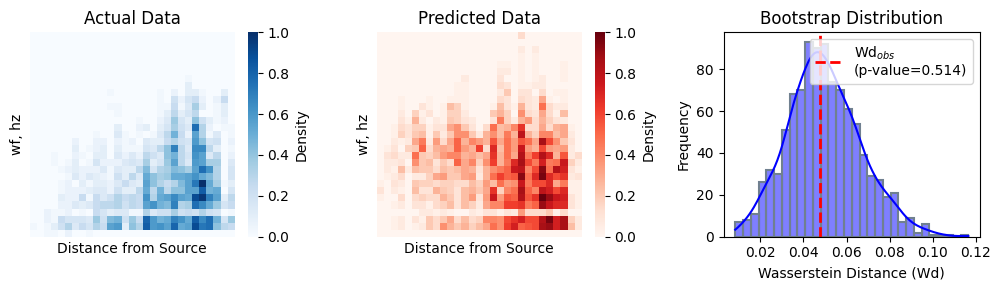

In [107]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz', 0,1)

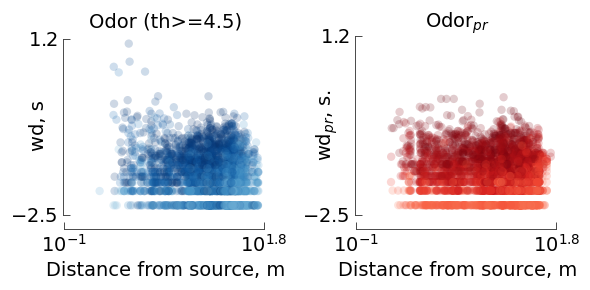

In [108]:
### WHIFF DURATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='Blues',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, c=fdf_predicted.mean_concentration, cmap='Reds',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)


ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$-2.5$', r'$1.2$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$-2.5$', r'$1.2$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])


mpl_functions.set_fontsize(f, 14)
f.tight_layout()


100%|██████████| 1000/1000 [00:00<00:00, 10136.04it/s]


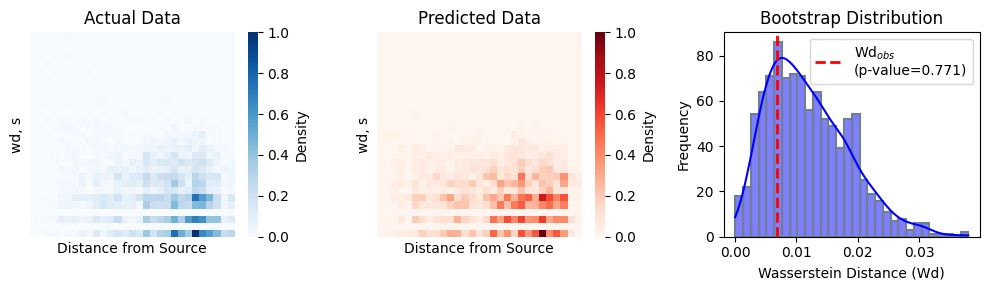

In [109]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'wd, s', 0,1)

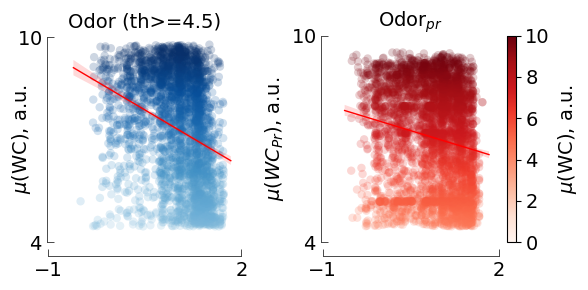

In [110]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='Blues', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='Reds', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


100%|██████████| 1000/1000 [00:00<00:00, 8465.82it/s]


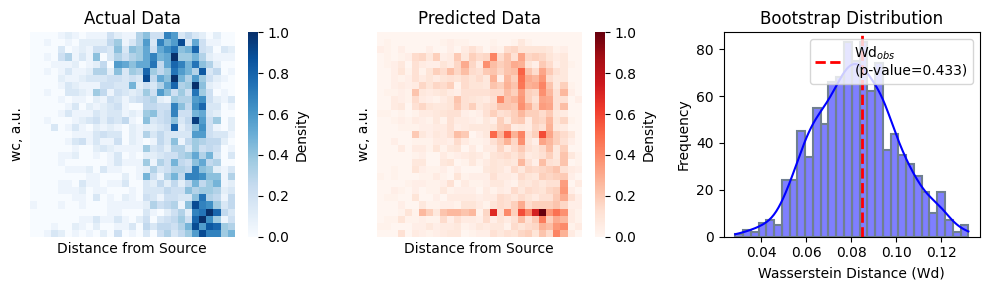

In [111]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.', 0,1)

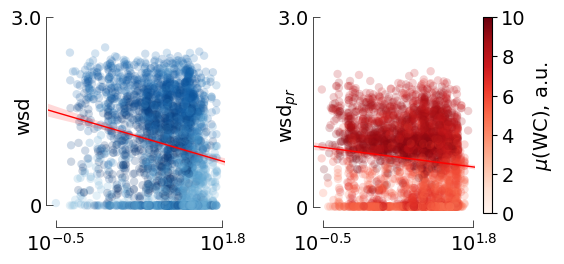

In [112]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='Blues', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='Reds', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('wsd')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$3.0$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$3.0$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9601.79it/s]


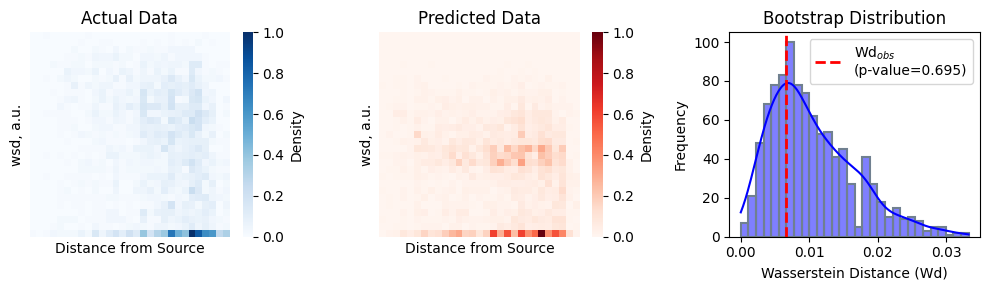

In [113]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,1)

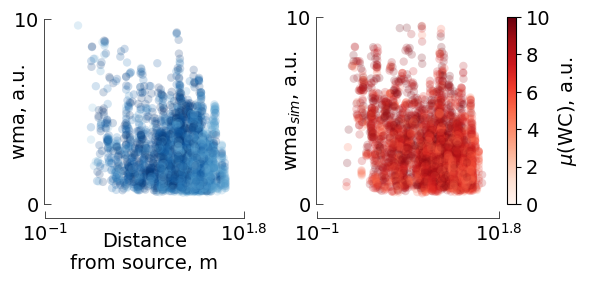

In [114]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='Blues', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

# g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
#                  ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log)20, m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='Reds', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

# g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
#                  ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_xlabel('Distance\nfrom source, m')
ax1.xaxis.set_label_coords(0.5, -0.15)
ax1.set_ylabel('wma, a.u.')
ax2.set_ylabel('wma$_{sim}$, a.u.')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


100%|██████████| 1000/1000 [00:00<00:00, 8708.74it/s]


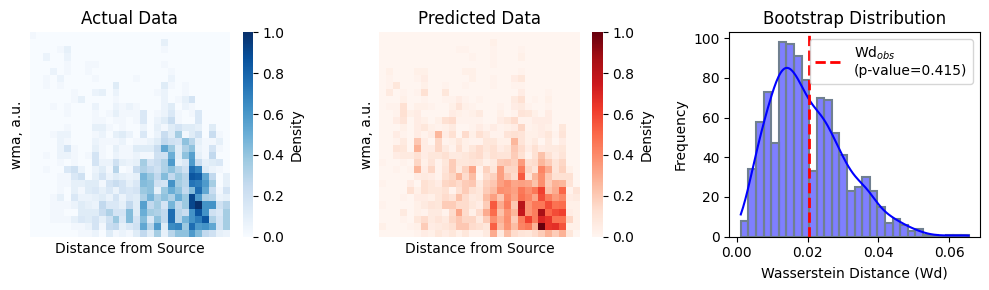

In [115]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,1)